In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!nvidia-smi

Mon Feb  8 15:47:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions
#from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub # can pip install
from glob import glob
import os

In [ ]:
# for plotting images (optional)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
# getting data
base_dir = '/content/drive/MyDrive/Colab Projects/food_dataset/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_french_fries = os.path.join(train_dir, 'french_fries')
train_waffles = os.path.join(train_dir, 'waffles')
validation_french_fries = os.path.join(validation_dir, 'french_fries')
validation_waffles = os.path.join(validation_dir, 'waffles')

num_french_fries_tr = len(os.listdir(train_french_fries))
num_waffles_tr = len(os.listdir(train_waffles))
num_french_fries_val = len(os.listdir(validation_french_fries))
num_waffles_val = len(os.listdir(validation_waffles))

total_train = num_french_fries_tr + num_waffles_tr
total_val = num_french_fries_val + num_waffles_val
print(total_train)
print(total_val)

200
40


In [ ]:
# useful for getting number of output classes
folders = glob(train_dir + '/*')
folders

['/content/drive/MyDrive/Colab Projects/food_dataset/train/waffles',
 '/content/drive/MyDrive/Colab Projects/food_dataset/train/french_fries']

In [ ]:
BATCH_SIZE = 5
# re-size all the images to this
IMAGE_SIZE = [224, 224] # match image dimension to mobile net input
IMG_SIZE = 224

In [ ]:
#normalize image
# Use the Image Data Generator to import the images from the dataset
#prevent memorization
train_image_generator = ImageDataGenerator(
    rescale=1./255
    )

validation_image_generator = ImageDataGenerator(
    rescale=1./255)

In [ ]:
# Make sure you provide the same target size as initialised for the image size
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SIZE,IMG_SIZE),
                                                           class_mode='categorical')#could be 'binary'

val_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=validation_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_SIZE,IMG_SIZE),
                                                           class_mode='categorical')

Found 200 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Model

In [ ]:
# getting MobileNet
# Here we will be using imagenet weights
mobile_net = MobileNet(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#view structure of mobilenet
#mobile_net.summary()
# don't train existing weights
mobile_net.trainable = False

In [ ]:
model = model = tf.keras.models.Sequential([
    mobile_net,
    Flatten(),
    tf.keras.layers.Dense(len(folders), activation='softmax') 
    ])

In [ ]:
# tell the model what cost and optimization method to use
model.compile(optimizer='adam',
              loss='categorical_crossentropy', #for 2 classes?'binary_crossentropy' 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

In [ ]:
# view the structure of the model
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_5 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 100354    
Total params: 3,329,218
Trainable params: 100,354
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
EPOCHS = 5

In [ ]:
# fit the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
    )

Epoch 1/5
40/40 [==============================] - 3s 43ms/step - loss: 3.9986 - accuracy: 0.7029 - val_loss: 0.9558 - val_accuracy: 0.9250
Epoch 2/5
40/40 [==============================] - 1s 34ms/step - loss: 0.3099 - accuracy: 0.9817 - val_loss: 1.3574 - val_accuracy: 0.8500
Epoch 3/5
40/40 [==============================] - 1s 33ms/step - loss: 0.0813 - accuracy: 0.9910 - val_loss: 0.0739 - val_accuracy: 0.9750
Epoch 4/5
40/40 [==============================] - 1s 33ms/step - loss: 7.9910e-07 - accuracy: 1.0000 - val_loss: 0.0904 - val_accuracy: 0.9750
Epoch 5/5
40/40 [==============================] - 1s 33ms/step - loss: 1.3778e-06 - accuracy: 1.0000 - val_loss: 0.0905 - val_accuracy: 0.9750


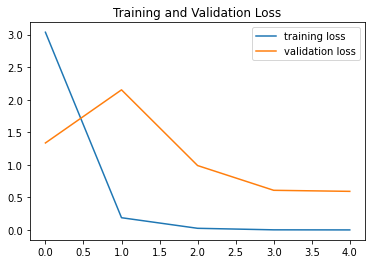

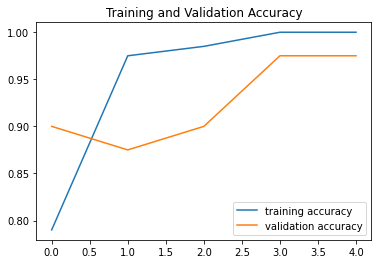

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
#plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
#plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

Save model

In [ ]:
model.save('model1_mobilenet.h5')

In [ ]:
y_pred = model.predict(val_data_gen)
y_pred

array([[1.0000000e+00, 3.2663638e-23],
       [1.0000000e+00, 3.3262514e-17],
       [9.7633922e-01, 2.3660742e-02],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 6.2808497e-15],
       [1.0000000e+00, 7.9868644e-20],
       [3.1138418e-02, 9.6886158e-01],
       [1.0000000e+00, 2.0424014e-23],
       [9.9998033e-01, 1.9672008e-05],
       [1.0000000e+00, 4.1025391e-37],
       [1.0000000e+00, 3.1945179e-11],
       [1.0000000e+00, 3.2524324e-34],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.2587449e-27],
       [1.0000000e+00, 7.1770506e-33],
       [1.0000000e+00, 6.6503233e-21],
       [1.0000000e+00, 4.3632467e-16],
       [9.9552250e-01, 4.4774977e-03],
       [1.0000000e+00, 1.4143791e-16],
       [1.0000000e+00, 1.4782128e-17],
       [1.6249750e-38, 1.0000000e+00],
       [3.2664005e-31, 1.0000000e+00],
       [8.3805047e-37, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [5.7487930e-21, 1.0000000e+00],
       [1.1630022e-15, 1.

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=0)
y_pred

array([ 0, 20])

Load model

In [ ]:
model=load_model('model1_mobilenet.h5')

Prepare image to fit the images the model was trained on

In [ ]:
img=image.load_img('/content/drive/MyDrive/Colab Projects/food_dataset/test/waffles/283190.jpg',target_size=(224,224))

x=image.img_to_array(img)
x

array([[[47., 13., 12.],
        [50., 16., 15.],
        [57., 23., 22.],
        ...,
        [49., 53., 54.],
        [51., 52., 54.],
        [49., 50., 52.]],

       [[64., 30., 29.],
        [57., 23., 22.],
        [54., 20., 19.],
        ...,
        [53., 57., 58.],
        [54., 55., 57.],
        [57., 58., 60.]],

       [[68., 34., 33.],
        [71., 37., 36.],
        [69., 35., 34.],
        ...,
        [56., 60., 61.],
        [58., 59., 61.],
        [57., 58., 60.]],

       ...,

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [75., 76., 81.],
        [73., 74., 79.],
        [76., 77., 82.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [72., 73., 77.],
        [70., 71., 75.],
        [72., 73., 77.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [71., 70., 75.],
        [71., 70., 75.],
        [69., 68., 73.]]

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
Note: the subdirectories of images, one for each class, are loaded by the flow_from_directory() function in alphabetical order and assigned an integer for each class. The subdirectory “cat” comes before “dog“, therefore the class labels are assigned the integers: cat=0, dog=1. This can be changed via the “classes” argument in calling flow_from_directory() when training the model.
CATEGORIES = ["French fries", "Waffles"]

In [ ]:
prediction = model.predict(img_data)
print(prediction)
print(CATEGORIES[int(prediction[0][0])])

[[9.9979061e-01 2.0945848e-04]]
French fries


In [ ]:
a=np.argmax(prediction, axis=1)
print(CATEGORIES[int(a[0])])

French fries


In [ ]:
a==0

array([ True])

In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
#from keras.applications import imagenet_utils

In [ ]:
# load and prepare the image
def load_image(filename):
  # load the image
  img = load_img(filename, target_size=(224, 224))
  # convert to array
  img = img_to_array(img)
  img = img/255
  # reshape into a single sample with 3 channels
  img = img.reshape(1, 224, 224, 3)
  # center pixel data
  img = img.astype('float32')
  img = img - [123.68, 116.779, 103.939]
  #img=preprocess_input(img)

  #img_array = image.img_to_array(img)
  #img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  #return preprocess_input(img_array_expanded_dims)

  return img

In [ ]:
# load an image and predict the class

# load the image
img = load_image('/content/drive/MyDrive/Colab Projects/food_dataset/train/french_fries/100148.jpg')
# load model
#model = load_model('final_model.h5')
# predict the class
result = model.predict(img)

#results = decode_predictions(result)
#print(results)

print(result[0])
print(int(result[0][0]))
print(CATEGORIES[int(result[0][0])])
 

NameError: ignored